In [2]:
%matplotlib inline
import seaborn as sns
import numpy as np
import re

In [3]:
def str2time(s):
        ls = list(map(lambda x : float(x), s.split(':'))) # hh : mm : ss : ms : ???

        return round(ls[0] * 3600 + ls[1] * 60 + ls[2] + ls[3] / 1000., 2)

In [113]:
def get_evolution_from_log():
    evolution = [[ [] for j in range(M) ] for i in range(0,N)]

    max_time = 0.
    max_val = 0.

    for ln in open(filename,"r").readlines():
        if ln.startswith("0 / L / Y /"):

            time = re.compile(r"\d+:\d+:\d+:\d+:\d+[\.\d+]*").search(ln.split('/')[3]).group(0)
            cell = re.compile(NOMBRE_MODELO_CELL_DEVS + "\(\d+,\d+,0\)\(\d*\) / out /[ ]*-*\d+[\.\d+]*").findall(ln)
            if len(cell) == 0:
                continue
            else:
                cell = cell[0]
                coord = re.search(re.compile(r"\(.*,.*,0\)"), cell).group(0)[1:-1].split(',')
                i, j = int(coord[0]), int(coord[1])
                #print(cell)
                #print(i, j)
                #if i==0 and j==0:
                val  = re.compile(r"-*\d+[\.\d+]*").search(cell.split('/')[2]).group(0)
                evolution[i][j].append({
                    "time" : time,
                    "time_converted" : str2time(time),
                    "val" : float(val)
                })
                max_time = max(max_time, str2time(time))
                max_val = max(max_val, val)
    return evolution, max_time

In [114]:
def get_cut_values(ev, pts):
    res = []
    i, j = 0, 0
    while i < len(ev)-1:
        if (ev[i]['time_converted'] <= pts[j] and ev[i+1]['time_converted'] > pts[j]) \
            or ev[i]['time_converted'] > pts[j]:
            res.append({
                'time' : pts[j], 
                'interval' : (ev[i]['time_converted'], ev[i+1]['time_converted']),
                'value' : ev[i]['val']
            })
            j = j+1        
        else:
            i = i + 1
    while j < len(pts):
        res.append({
            'time' : pts[j],
            'interval' : (ev[i-1]['time_converted'], ev[i]['time_converted']),
            'value' : ev[i]['val']
        })
        j = j+1  
    return res

# Ejemplos

In [115]:
# PARAMS
NOMBRE_EXPERIMENTO = 'exp_pedro_1'
NOMBRE_CARPETA = '100_1_0.2_0.4_0.4'
NOMBRE_ARCHIVO = 'new_log_valfile_exp_00.log'
NOMBRE_MODELO_CELL_DEVS = 'opinion'

MODELO = 'opinion-goodwin-minsky'

filename = '../modelos/' + NOMBRE_MODELO_CELL_DEVS + '/' + MODELO + '/experimentos/' \
            + NOMBRE_EXPERIMENTO + '/' + NOMBRE_CARPETA \
            +'/result_logs/' + NOMBRE_ARCHIVO

# Parametros
N = 10
M = 10

# Cantidad de instantes en los que quiero conocer el valor exacto de cada celda
n_cuts = 100

# Calculo
evolution, max_time = get_evolution_from_log()
evolution_values = [[ [] for j in range(M) ] for i in range(0,N)]
pts = np.linspace(0,max_time, n_cuts)
for i in range(0,N):
    for j in range(0,M):
        evolution_values[i][j] = get_cut_values(evolution[i][j], pts)

In [138]:
# Params
N_lim = 9
M_lim = 9

# Enter cell to plot evolution
x = list(map(lambda x : x['time'], evolution_values[0][0]))
xs = [list(map(lambda x : x['value'], evolution_values[i][j])) 
      for i in range(0,N_lim+1) for j in range(0,M_lim+1)]
z = list(map(sum, zip(*xs)))      

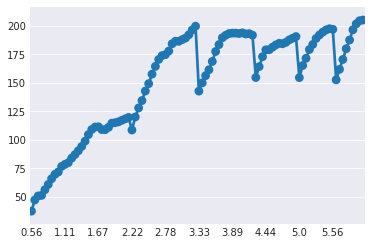

In [139]:
sns.set_style("darkgrid")
ax = sns.pointplot(x=list(map(lambda a : round(a,2), x)), y=z)
#ax.set_ylim(-15,15)

import matplotlib.ticker as ticker
tick_spacing = 10
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))